In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

import theano
import theano.tensor as T

### Reading inputs

In [2]:
answer_cols = ["Ans_"+str(i+1) for i in range(30)]
N = len(answer_cols)   # Number of questions
L_set = ["CA", "A", "N", "D", "CD", "NO"]
L = len(L_set)      # Number of possible answers

## Reading user info
U = pd.read_csv('data/input_to_algorithm.csv', index_col=0, low_memory=False)
M = len(U) # Number of users
assert U.shape[1], N
print "Users input size (M x N): ", U.shape

ans_enc = OneHotEncoder(sparse=False)
U = ans_enc.fit_transform(U)
U = U.reshape(M, N, L)
print "One-hot (M x N x L):", U.shape, "\n"

## Reading party info
P = pd.read_csv('data/es_party_XYZ.csv', delim_whitespace=True)
P = P[answer_cols]
P[P==99] = 6
K = len(P) # Number of parties
print "Parties input size (K x N): ", P.shape

P = ans_enc.transform(P)
P = P.reshape(len(P), len(answer_cols), L)
print "One-hot (K x N x L):", P.shape, "\n"

## Reading voting intention
V = pd.read_csv('data/voting_intention.csv', header=None,index_col=0)
assert len(V), M
print "Voting intention input size (M):", len(V)

party_enc = OneHotEncoder(sparse=False)
V = party_enc.fit_transform(V)
assert K, V.shape[1]
print "One-hot (M x K)", V.shape, "\n"

Users input size (M x N):  (69037, 30)
One-hot (M x N x L): (69037, 30, 6) 

Parties input size (K x N):  (10, 30)
One-hot (K x N x L): (10, 30, 6) 

Voting intention input size (M): 69037
One-hot (M x K) (69037, 10) 



### Building model

In [76]:
def unfold_matrix(D_w):
    '''Gets the 13 independent parameters of the folded matrix and generate the double-symmetry matrix.
    -----------------------------------
    INPUT: a numeric vector of lenght 13.
    The order of the 13 parameters correspond to the following loctions in the matrix:
    0
    1 2
    3 4 5
    6 7
    8
    9 10 11    12'''
    
    return[[D_w[0], D_w[1], D_w[3], D_w[6], D_w[8], D_w[9]],
         [D_w[1], D_w[2], D_w[4], D_w[7], D_w[6], D_w[10]],
         [D_w[3], D_w[4], D_w[5], D_w[4], D_w[3], D_w[11]],
         [D_w[6], D_w[7], D_w[4], D_w[2], D_w[1], D_w[10]],
         [D_w[8], D_w[6], D_w[3], D_w[1], D_w[0], D_w[9]],
         [D_w[9], D_w[10], D_w[11], D_w[10], D_w[9], D_w[12]]]

def unfold_sum_matrix(mat):
    '''Gets a matrix, adds up all the elements that correspond to double-symmetrical positions and assign the
    result to such positions.'''
    L = 6
    temp_mat = np.copy(mat)
    
    ## Symmetry in the main diagonal
    for i in range(L):
        for j in range(L):
            if i != j:
                temp_mat[i,j] += mat[j, i]
    
    temp_mat2 = np.copy(temp_mat)
    ## Symmetry in the second diagonal (without No Opinions)
    for i in range(L):
        for j in range(L):
            if (j != 4-i) and (j != 5 and i != 5):
                temp_mat2[i,j] += temp_mat[4-j, 4-i]
            else:
                temp_mat2[i,j] = temp_mat[i,j]
    return temp_mat2

**Initialize weights randomly**

In [52]:
d_init = np.random.randn(N, 13) # 13 independent weights in the bi-symmetrical distance matrix
#w_init = np.random.randn(N)

**Or load pre-trained weights**

In [158]:
import pickle
with open('data/weights.pickle', 'rb') as f:
    #w_init, d_init = pickle.load(f)
    d_raw = pickle.load(f)
    d_init = d_raw.get_value()

**Or pick the hybrid model from Mendez**

In [51]:
## Not working properly, problem with No Opinions
d_init = [1,
          0.5,  0.625,
          0,    0.25,  0.5,
         -0.5, -0.125,
         -1,
          0,    0,     0,         0] # Hybrid model, NOs = 0
print np.array(unfold_matrix(d_init))

[[ 1.     0.5    0.    -0.5   -1.     0.   ]
 [ 0.5    0.625  0.25  -0.125 -0.5    0.   ]
 [ 0.     0.25   0.5    0.25   0.     0.   ]
 [-0.5   -0.125  0.25   0.625  0.5    0.   ]
 [-1.    -0.5    0.     0.5    1.     0.   ]
 [ 0.     0.     0.     0.     0.     0.   ]]


**Define model**

In [4]:
# Symbolic variables
u = T.dtensor3("u")
p = T.dtensor3("p")
v = T.dmatrix("v")

## Define learnable parameters
d = theano.shared(d_init, name="D") # 13 independent weights in the bi-symmetrical distance matrix

D = []
for j in range(N):
    D_w = d[j]
    D0 = T.stack([D_w[0], D_w[1], D_w[3], D_w[6], D_w[8], D_w[9]])
    D1 = T.stack([D_w[1], D_w[2], D_w[4], D_w[7], D_w[6], D_w[10]])
    D2 = T.stack([D_w[3], D_w[4], D_w[5], D_w[4], D_w[3], D_w[11]])
    D3 = T.stack([D_w[6], D_w[7], D_w[4], D_w[2], D_w[1], D_w[10]])
    D4 = T.stack([D_w[8], D_w[6], D_w[3], D_w[1], D_w[0], D_w[9]])
    D5 = T.stack([D_w[9], D_w[10], D_w[11], D_w[10], D_w[9], D_w[12]])
    D.append(T.stack([D0,D1,D2,D3,D4,D5]))

D = T.stack(D)                               
#w = theano.shared(w_init, name="w")

## Compute distance scores
s = T.batched_dot(u.dimshuffle((1,0,2)), D)
sd = T.batched_dot(s, p.dimshuffle((1,2,0)))
#s = T.nnet.sigmoid(s)

## Aggregate without weights
s = T.tensordot(sd, np.ones(N), axes=[[0],[0]])

## Aggregate with weights (deprecated)
#s = T.tensordot(sd, w, axes=[[0],[0]])
#s = T.nnet.sigmoid(s)

## Final outcome
s = T.nnet.softmax(s)

predict = theano.function(inputs=[u,p], outputs=s)
get_latent = theano.function(inputs=[u,p], outputs=sd)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


### Training model

In [113]:
training_steps = 8000
lambda0 = 0.01 # regularization parameter
mu = 1 # learning rate

err = T.nnet.categorical_crossentropy(s,v)
#cost = err.mean() + lambda0 * ((w ** 2).sum() + (d ** 2).sum())
cost = err.mean() + lambda0 * (d ** 2).sum()
#gw, gd = T.grad(cost, [w, d])
gd = T.grad(cost, d)

# Compile
train = theano.function(
          inputs=[u,p,v],
          outputs=[s, err],
          updates=[(d, d - mu * gd)])
        #updates=((w, w - mu * gw), (d, d - mu * gd)))

# Train
sample_every = 5
err_vec = np.zeros(training_steps / sample_every)
for i in range(training_steps):
    pred, error = train(U, P, V)
    if not i % sample_every:
        err_vec[i/sample_every] = error.mean()

        v_max = np.argmax(V,axis=1)
        p_max = np.argmax(predict(U,P), axis=1)
        acc = sum(v_max == p_max) / float(M)

        print "{:d}, {:.5f}, {:.5f}".format(i, err_vec[i], acc)
    
print("Final model:")
#print(w.get_value())
print(d.get_value())
print("target values for D:")
print(V)
print("prediction on D:")
print(predict(U,P))

0, 1.46500, 0.39682
5, 1.47027, 0.39550
10, 1.47634, 0.39470
15, 1.48217, 0.39309
20, 1.48739, 0.39162
25, 1.49192, 0.39007
30, 1.49577, 0.38886
35, 1.49901, 0.38814
40, 1.50171, 0.38734
45, 1.50397, 0.38701
50, 1.50585, 0.38644
55, 1.50741, 0.38587
60, 1.50872, 0.38550
65, 1.50981, 0.38505
70, 1.51072, 0.38465
75, 1.51149, 0.38449
80, 1.51214, 0.38417
85, 1.51268, 0.38390
90, 1.51314, 0.38362
95, 1.51353, 0.38348
100, 1.51386, 0.38359
105, 1.51414, 0.38336
110, 1.51438, 0.38310
115, 1.51458, 0.38317
120, 1.51476, 0.38326
125, 1.51491, 0.38320
130, 1.51503, 0.38319
135, 1.51514, 0.38306
140, 1.51524, 0.38301
145, 1.51532, 0.38310
150, 1.51539, 0.38298
155, 1.51545, 0.38288
160, 1.51550, 0.38285
165, 1.51555, 0.38285
170, 1.51559, 0.38287
175, 1.51562, 0.38287
180, 1.51565, 0.38281
185, 1.51567, 0.38281
190, 1.51570, 0.38281
195, 1.51572, 0.38279
200, 1.51573, 0.38279
205, 1.51575, 0.38281
210, 1.51576, 0.38275
215, 1.51577, 0.38271
220, 1.51578, 0.38266
225, 1.51579, 0.38265
230, 1.515

KeyboardInterrupt: 

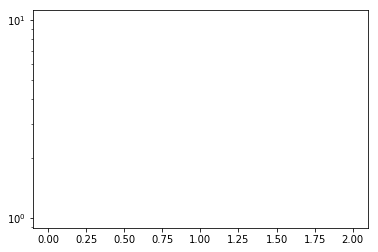

In [120]:
plt.semilogy(err_vec[0:3])

**Save parameters**

In [128]:
import pickle
name = "choose_your_name"
with open('data/'+ name +'.pickle', 'wb') as f:
    #pickle.dump([w.get_value(),d.get_value()], f)
    pickle.dump(d.get_value(), f)

### Analyse model

**Accuracy and confusion matrix**

Accuracy: 0.38262091342323684
0
1
2


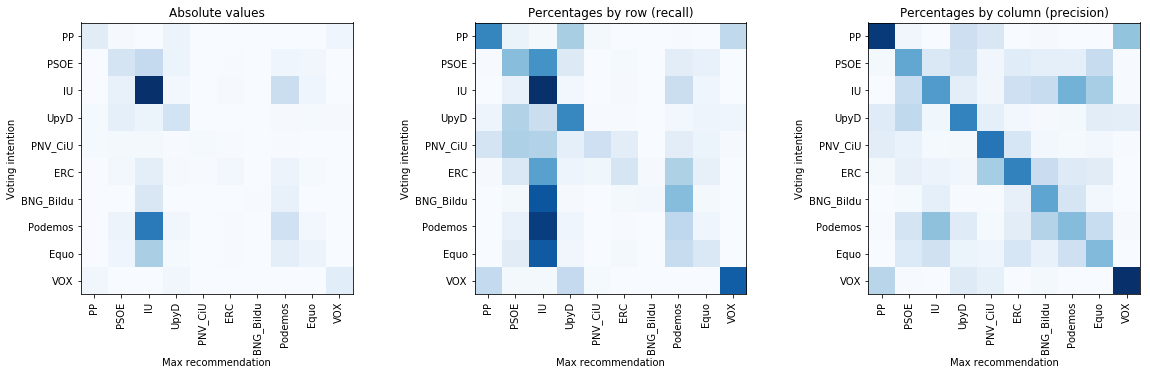

In [123]:
party_info = pd.read_csv('data/es_party_XYZ.csv', delim_whitespace=True)
party_info = party_info['Party_ID']

v_max = np.argmax(V,axis=1)
p_max = np.argmax(predict(U,P),axis=1)
acc = sum(v_max == p_max) / float(M)
print "Accuracy:", acc

conf = np.zeros((K,K))
for i in range(M):
    conf[v_max[i], p_max[i]] += 1

confs = []
for i in range(3):
    confs.append(conf.copy())

fig3,ax3 = plt.subplots(1,3, figsize=((20,5)))
for i,el in enumerate(['Absolute values','Percentages by row (recall)', 'Percentages by column (precision)']):
    conf = confs[i]
    for k in range(K):
        if i == 1:
            conf[k,:] = conf[k,:] / sum(conf[k,:])
        elif i == 2:
            conf[:,k] = conf[:,k] / sum(conf[:,k])

    ax3[i].xaxis.set(ticks=range(K), ticklabels=party_info)#, ticks_position="top", label_position="top")
    ax3[i].set_xticklabels(party_info, rotation=90)
    ax3[i].yaxis.set(ticks=range(K), ticklabels=party_info)#, ticks_position="right", label_position="right")
    ax3[i].set(xlabel="Max recommendation", ylabel="Voting intention", title=el)
    cax = ax3[i].imshow(100*conf, cmap='Blues')#, vmin=0, vmax=100)
    print i

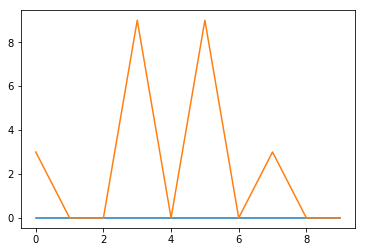

In [32]:
plt.plot(v_max[:10])
plt.plot(p_max[:10])

In [33]:
pred = predict(U,P)
pred[7]
pred[1]

array([0.14176993, 0.26209804, 0.04470597, 0.29837482, 0.03778236,
       0.00445189, 0.0041928 , 0.02002869, 0.01759826, 0.16899725])

In [124]:
D_end = np.array([unfold_matrix(el) for el in d.get_value()])
#u_agg = np.sum(U[:,j,:], axis=0)

# Frequencies
freq_abs = np.zeros_like(D_end)
scores = np.zeros_like(D_end)
freq_party = np.zeros((N, K, L))
for j in range(N):
    for k in range(K):
        for i in range(M):
            u_choice = np.argmax(U[i,j])
            p_choice = np.argmax(P[k,j])
            
            ## Absolute
            freq_abs[j, u_choice, p_choice] += 1
            
            ## Per party
            if v_max[i] == k:
                freq_party[j, k, u_choice] += 1
      
    scores[j] = np.multiply(freq_abs[j], D_end[j])

In [90]:
scores = np.zeros_like(D_end)
for j in range(N):
    scores[j] = np.multiply(freq_abs[j], D_end[j])

In [ ]:
## Weighted distance matrices (deprecated)
#w_end = w.get_value()

#d_map = []
#for j in range(N):
    #d_map.append(w_end[j] * d_end[j])
#combined_data = np.array(d_map)

In [73]:
questions = ["Spain should drop the Euro as a currency",
"A single member state should be able to block a treaty change, even if all the other members states agree to it",
"The right of EU citizens to work in Spain should be restricted",
"There should be a common EU foreign policy even if this limits the capacity of Spain to act independently",
"The EU should redistribute resources from richer to poorer EU regions",
"Overall, EU membership has been a bad thing for Spain",
"EU treaties should be decided by the Cortes Generales rather than by citizens in a referendum.",
"To address financial crises, the EU should be able to borrow money just like states can",
"Free market competition makes the health care system function better",
"The number of public sector employees should be reduced",
"The state should intervene as little as possible in the economy",
"Wealth should be redistributed from the richest people to the poorest",
"Cutting government spending is a good way to solve the economic crisis",
"It should be easy for companies to fire people",
"External loans from institutions such as the IMF are a good solution to crisis situations.",
"Protecting the environment is more important than fostering economic growth",
"Immigrants must adapt to the values and culture of Spain",
"Restrictions on citizen privacy are acceptable in order to combat crime",
"To maintain public order, governments should be able to restrict demonstrations",
"Less serious crimes should be punished with community service, not imprisonment",
"Same sex couples should enjoy the same rights as heterosexual couples to marry",
"Women should be free to decide on matters of abortion",
"The recreational use of cannabis should be legal",
"Islam is a threat to the values of Spain",
"The government is making unnecessary concessions to ETA",
"The Church enjoys too many privileges",
"The process of territorial decentralisation has gone too far in Spain",
"Citizens should directly elect their candidates through primary elections",
"The possibility of independence for an Autonomous Community should be recognized by the Constitution			",
"Spain should toughen up its immigration policy"]

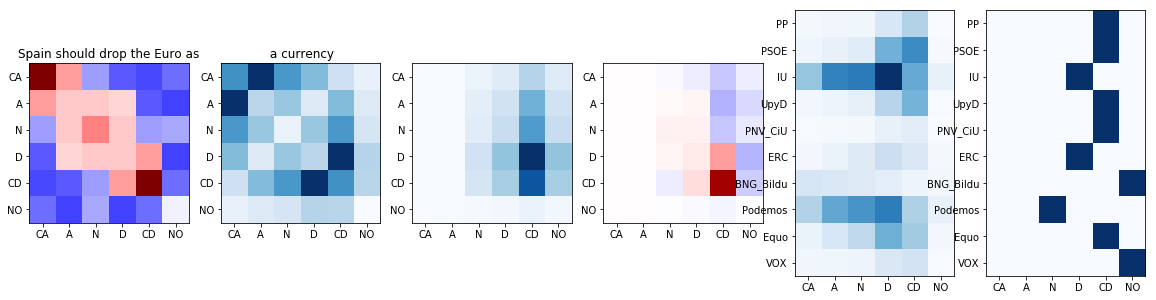

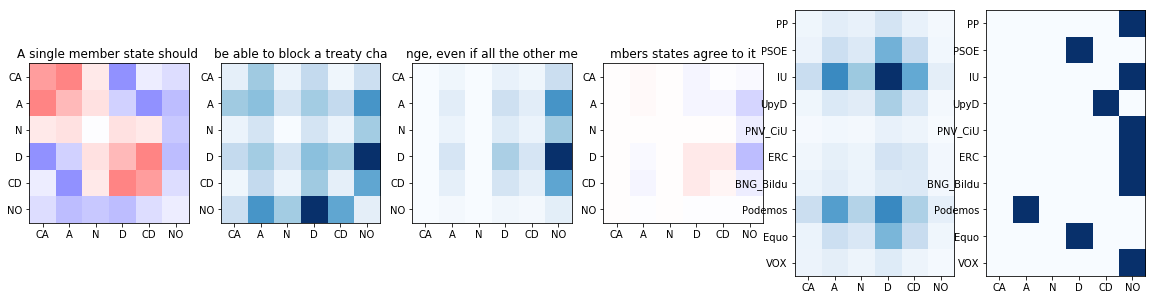

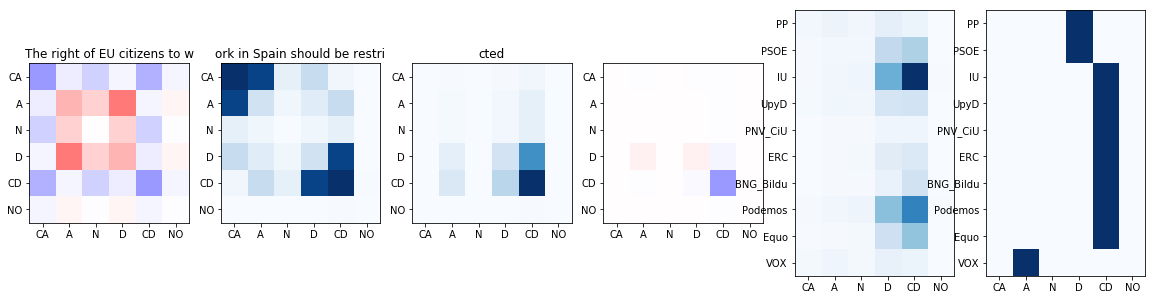

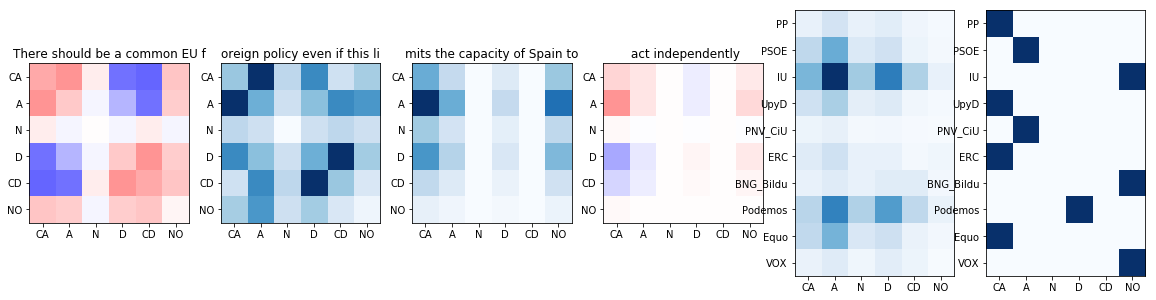

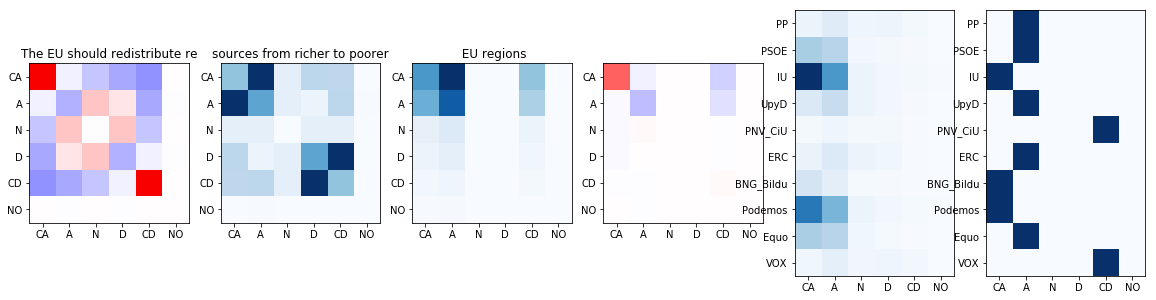

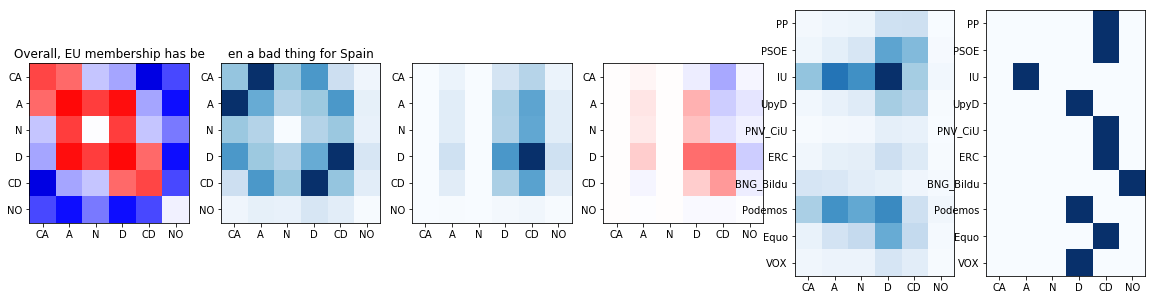

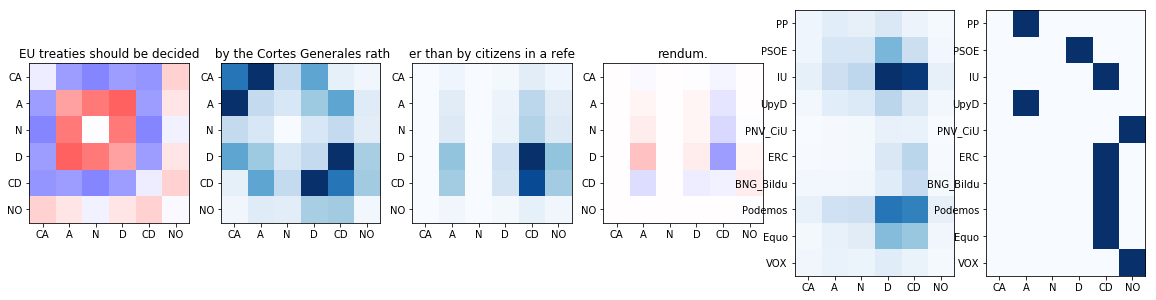

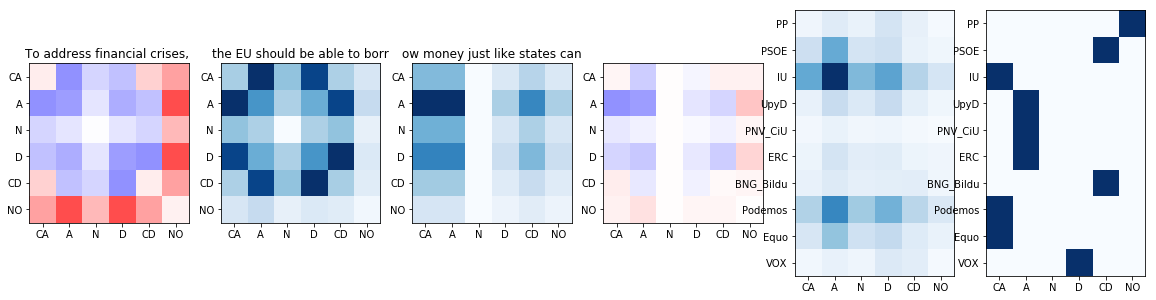

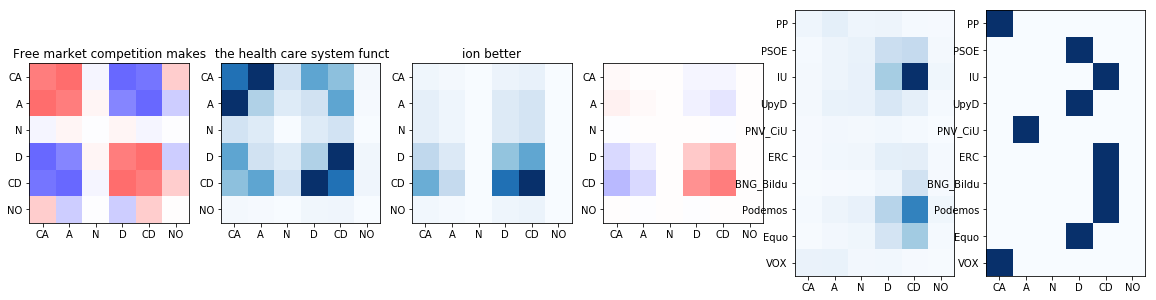

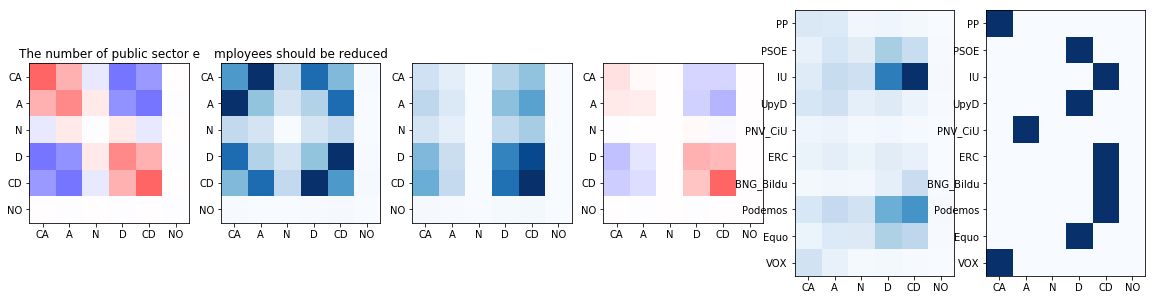

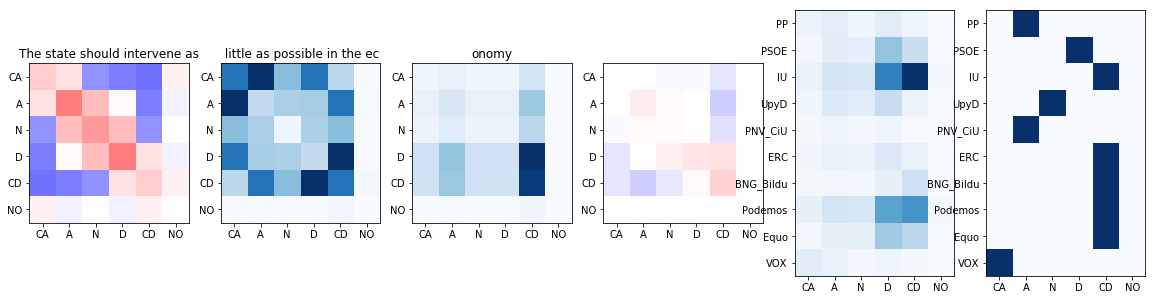

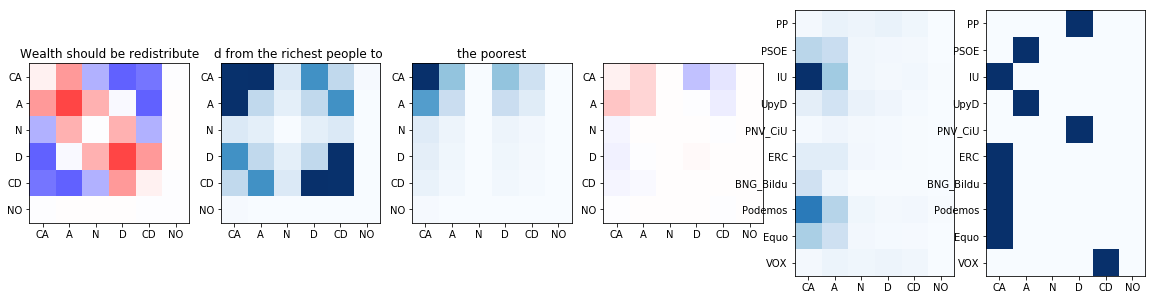

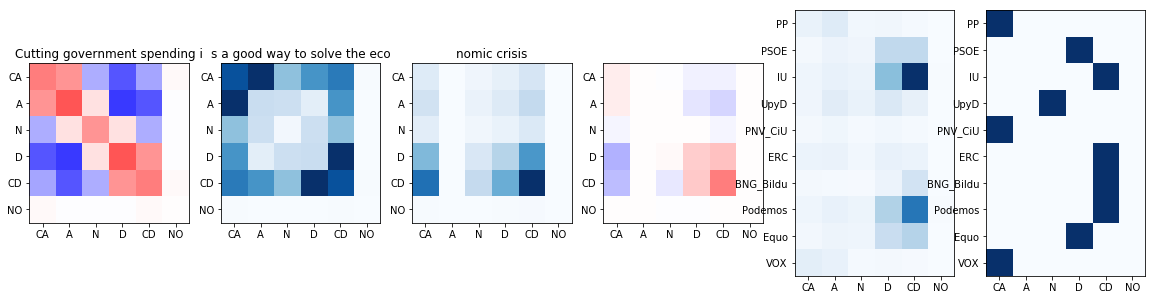

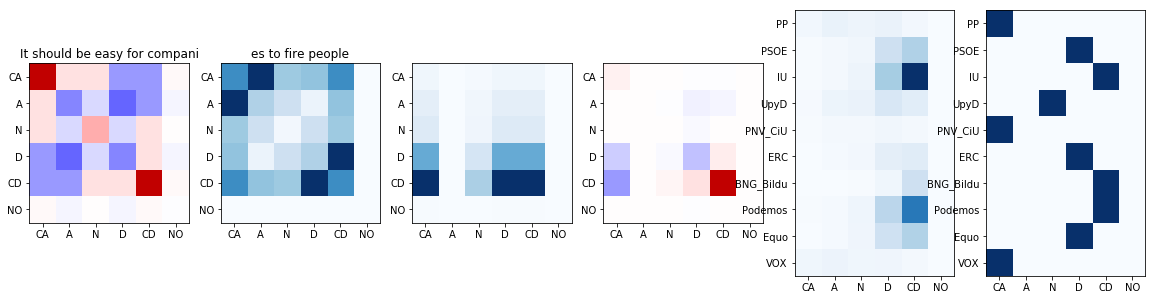

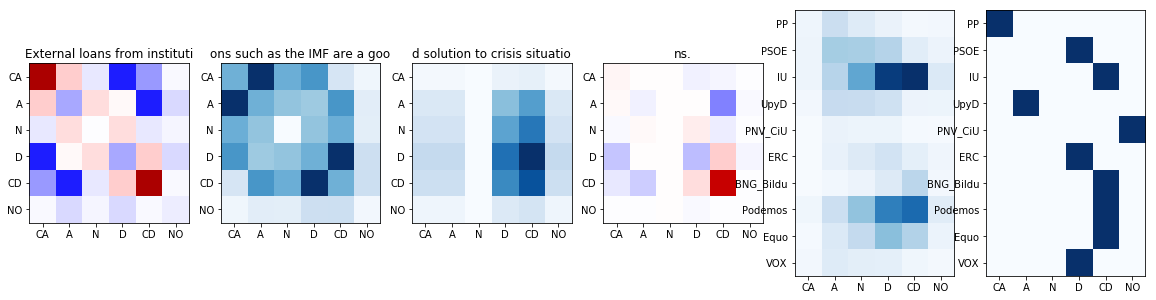

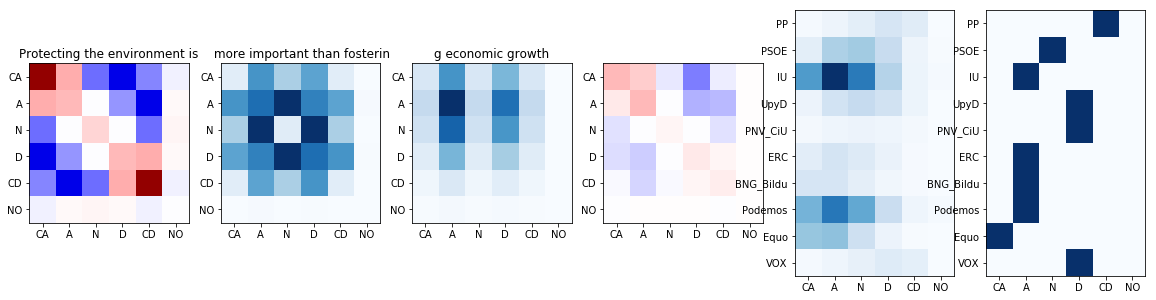

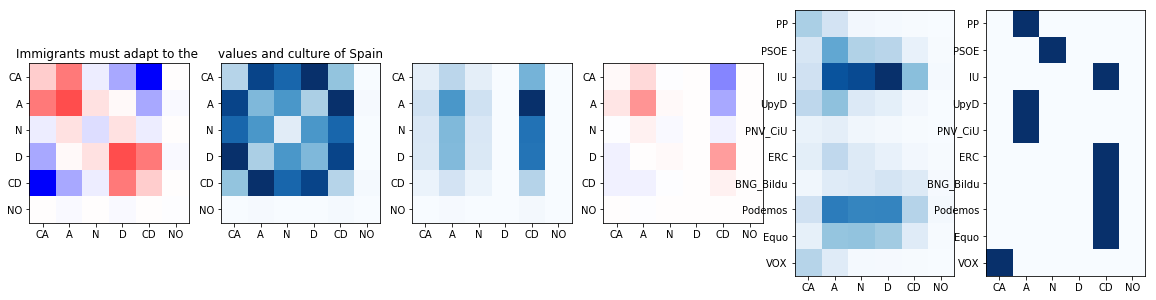

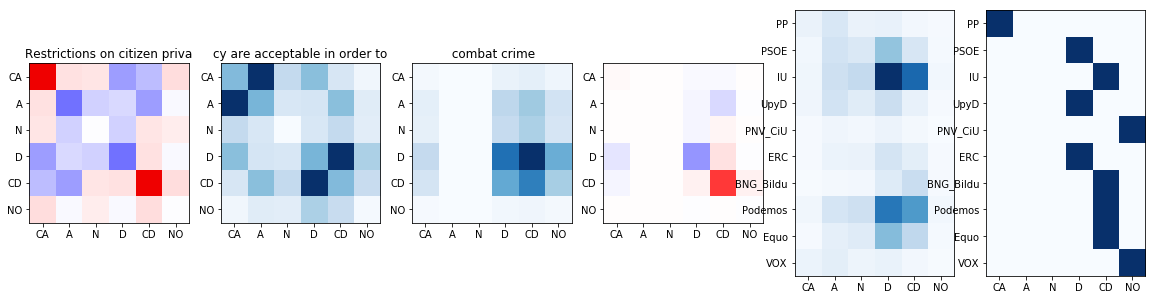

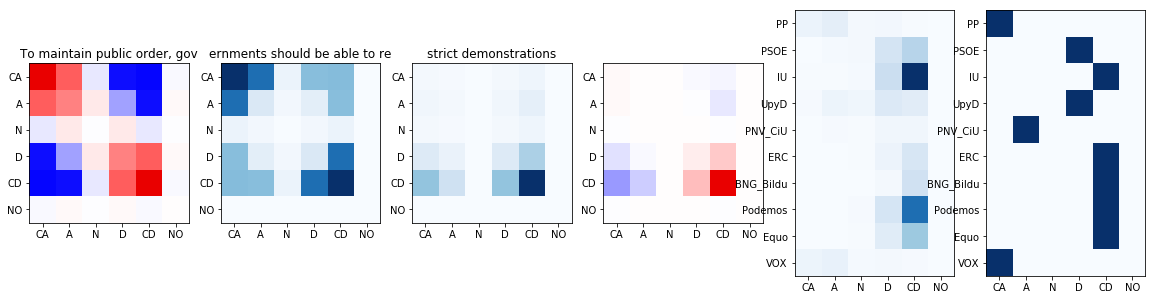

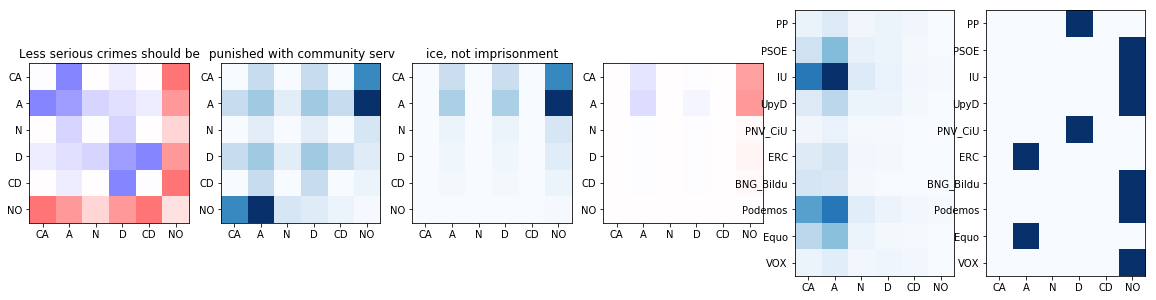

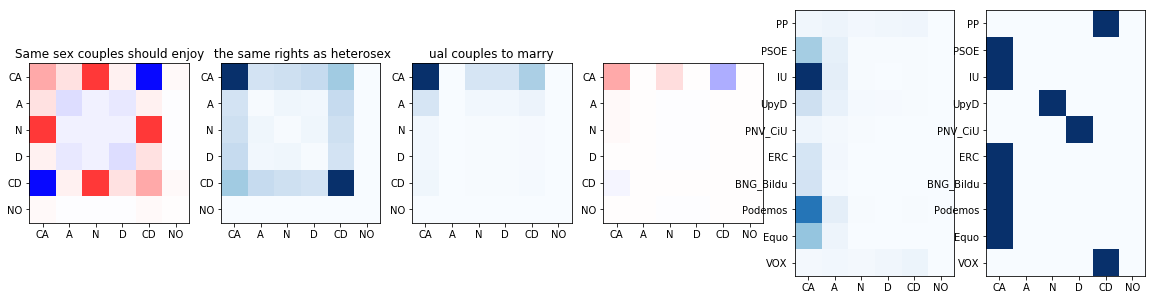

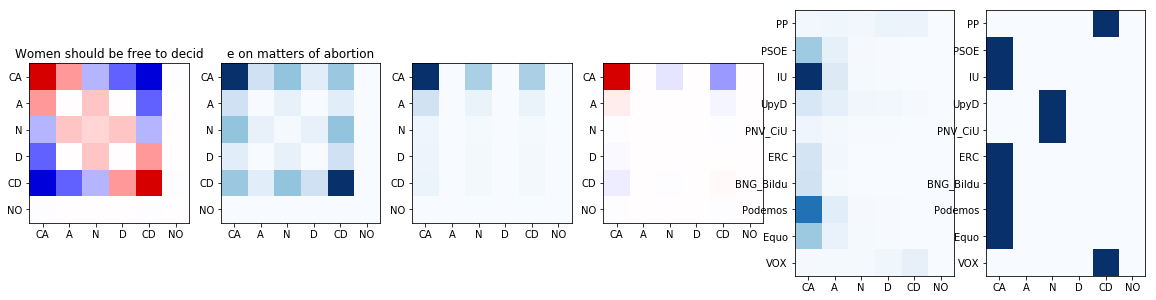

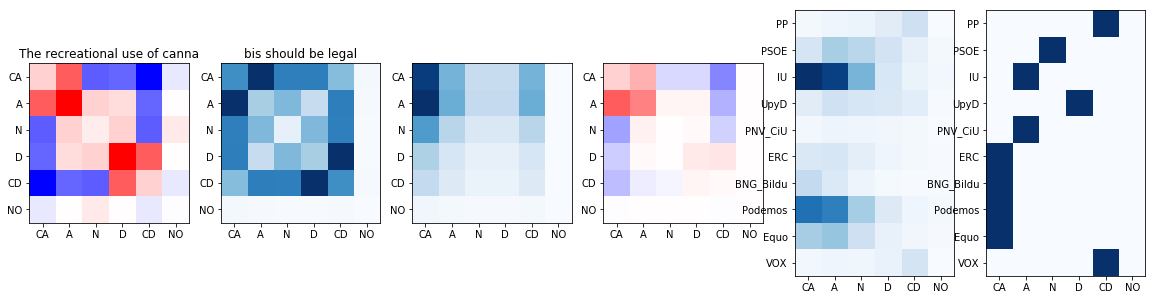

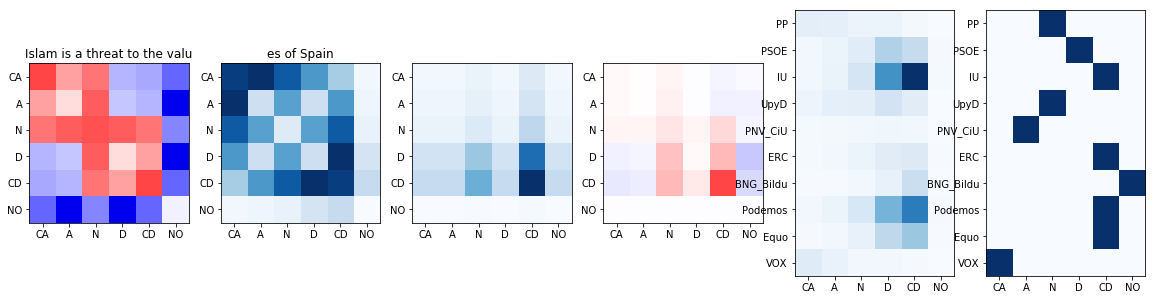

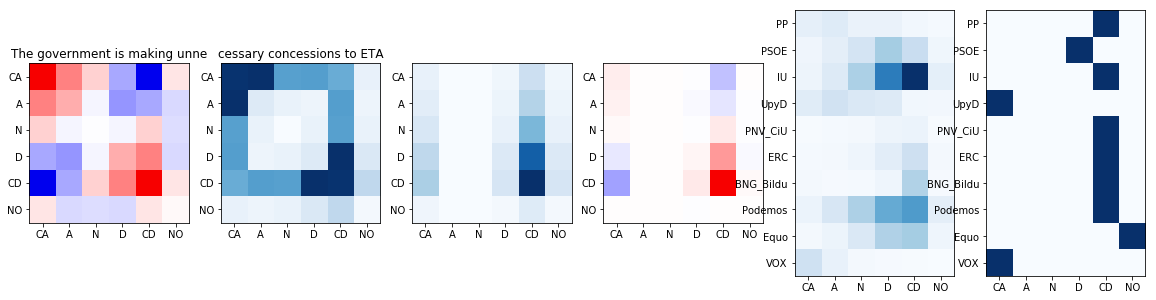

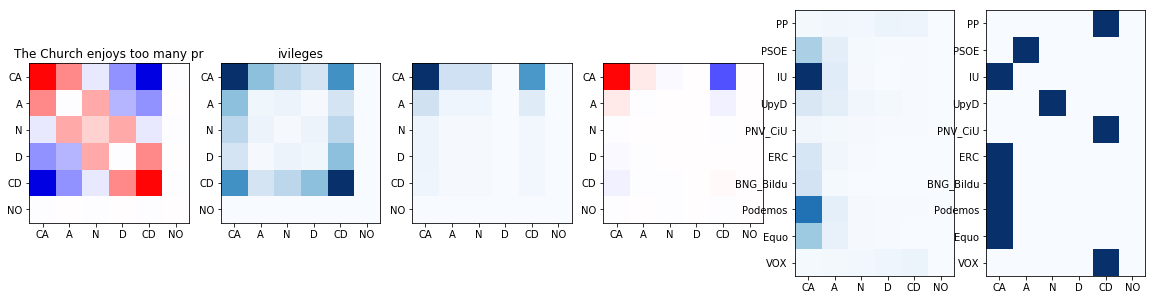

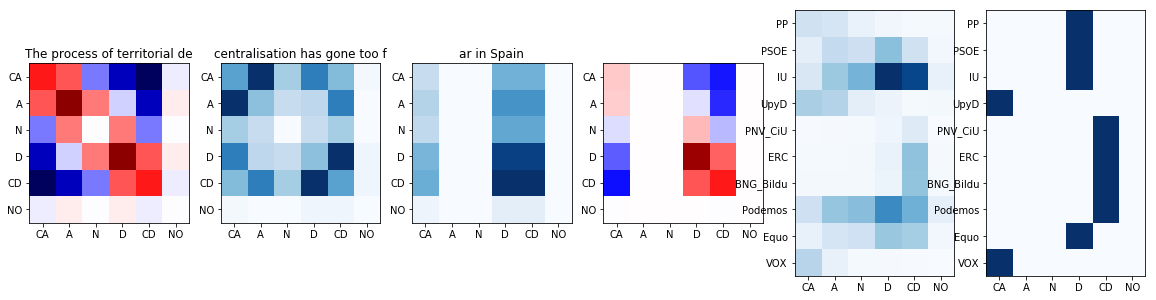

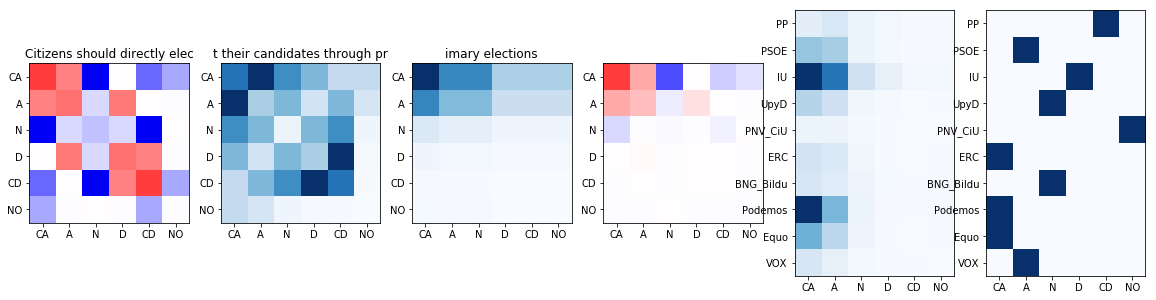

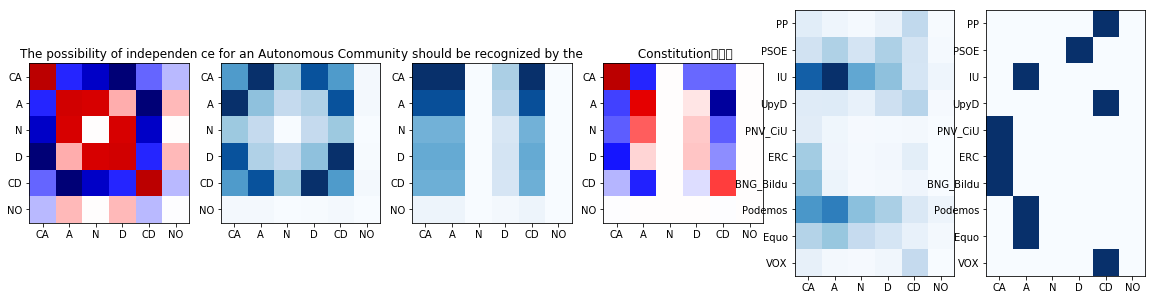

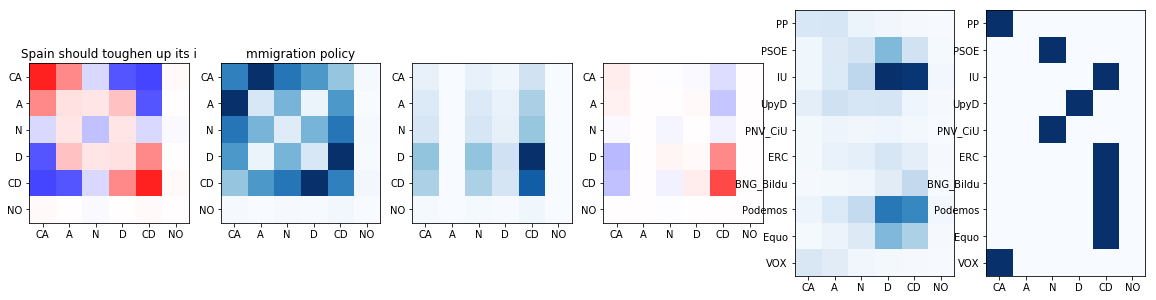

In [125]:
letters_per_line = 29
_max_D = np.amax(abs(D_end))
#_max_s = np.amax(abs(scores))

for j in range(N):
    fig3,ax3 = plt.subplots(1,6, figsize=((20,5)))
    i = 0
    
    # Distance matrices
    cax = ax3[i].imshow( D_end[j], cmap='seismic', vmin = -_max_D, vmax = _max_D)
    ax3[i].set( title = questions[j][0:letters_per_line] )
    ax3[i].xaxis.set( ticks = range(L), ticklabels = L_set)
    ax3[i].yaxis.set( ticks = range(L), ticklabels = L_set)
    i += 1
    
    # Mirrored frequencies (for verifying there was enough training data for the weights)
    freq_mirr = unfold_sum_matrix(freq_abs[j])
    cax = ax3[i].imshow(freq_mirr , cmap='Blues')
    ax3[i].set( title = questions[j][letters_per_line:2*letters_per_line] )
    ax3[i].xaxis.set(ticks=range(L),ticklabels=L_set)
    ax3[i].yaxis.set(ticks=range(L),ticklabels=L_set)
    i += 1
    
    # Absolute frequencies
    cax = ax3[i].imshow( freq_abs[j], cmap='Blues')
    ax3[i].set(title=questions[j][2*letters_per_line:3*letters_per_line])
    ax3[i].xaxis.set( ticks=range(L), ticklabels=L_set )
    ax3[i].yaxis.set( ticks=range(L), ticklabels=L_set )
    i += 1
    
    # Middle scores (for verifying which weights are being significative)
    #_max_s = np.amax(abs(scores[j]))
    cax = ax3[i].imshow( np.multiply(D_end[j], freq_abs[j]/np.max(freq_abs[j])), cmap='seismic', vmin = -_max_D, vmax = _max_D)
    ax3[i].set(title=questions[j][3*letters_per_line:4*letters_per_line])
    ax3[i].xaxis.set( ticks=range(L), ticklabels=L_set )
    ax3[i].yaxis.set( ticks=range(L), ticklabels=L_set )
    i += 1
    
    # Party frequencies
    ax3[i].xaxis.set(ticks=range(L),ticklabels=L_set)
    ax3[i].yaxis.set(ticks=range(K),ticklabels=party_info)
    cax = ax3[i].imshow( freq_party[j], cmap='Blues', vmin=0)#, vmax=M)
    i += 1
    
    # Party answers
    cax = ax3[i].imshow( P[:,j,:], cmap='Blues')
    ax3[i].xaxis.set(ticks=range(len(L_set)),ticklabels=L_set)
    ax3[i].yaxis.set(ticks=range(K),ticklabels=party_info)
    i += 1

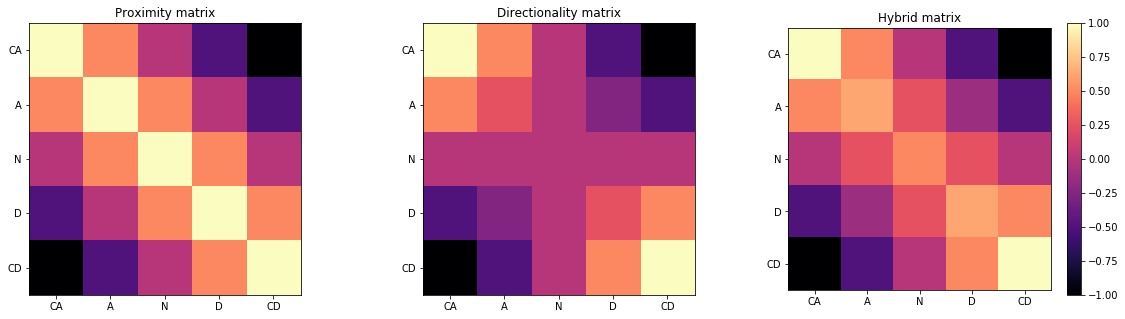

In [61]:
fig,ax = plt.subplots(1,3, figsize=((20,5)))

mat = [[1,0.5,0,-0.5,-1],
 [0.5,1,0.5,0,-0.5],
 [0,0.5,1,0.5,0],
 [-0.5,0,0.5,1,0.5],
 [-1,-0.5,0,0.5,1]]

ax3 = ax[0]
ax3.set(title="Proximity matrix")
ax3.set_yticklabels(L_set)
ax3.set_xticklabels(L_set)
cax = ax3.imshow(mat, cmap='magma')

mat = [[1,0.5,0,-0.5,-1],
     [0.5,0.25,0,-0.25,-0.5],
     [0,0,0,0,0],
     [-0.5,-0.25,0,0.25,0.5],
     [-1,-0.5,0,0.5,1]]

ax3 = ax[1]
cax = ax3.imshow(mat, cmap='magma')
ax3.set(title="Directionality matrix")
ax3.set_yticklabels(L_set)
ax3.set_xticklabels(L_set)

mat = [[1,0.5,0,-0.5,-1],
       [0.5,0.625,0.25,-0.125,-0.5],
       [0,0.25,0.5,0.25,0],
       [-0.5,-0.125,0.25,0.625,0.5],
       [-1,-0.5,0,0.5,1]]

ax3 = ax[2]
cax = ax3.imshow(mat, cmap='magma')
ax3.set(title="Hybrid matrix")
ax3.set_yticklabels(L_set)
ax3.set_xticklabels(L_set)
fig.colorbar(cax)

<Container object of 30 artists>

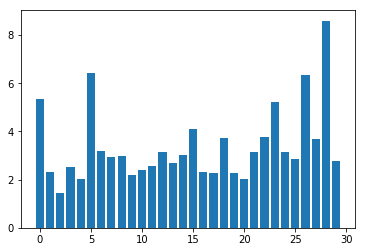

In [127]:
plt.bar(range(N), [sum(sum(abs(el))) for el in D_end])

In [37]:
print T.nnet.confusion_matrix.func_doc


    Computes the confusion matrix of given vectors containing
    actual observations and predicted observations.

    Parameters
    ----------
    actual : 1-d tensor variable
    pred : 1-d tensor variable

    Returns
    -------
    conf_mat : Confusion matrix of actual and predictions observations as shown below.

               | Predicted
    ___________|___________
       Actual  |
               |

    order : 1-d array of order of entries in rows and columns

    Examples
    --------
    >>> import theano
    >>> from theano.tensor.nnet import confusion_matrix

    >>> x = theano.tensor.vector()
    >>> y = theano.tensor.vector()
    >>> f = theano.function([x, y], confusion_matrix(x, y))
    >>> y_true = [2, 0, 2, 2, 0, 1]
    >>> y_pred = [0, 0, 2, 2, 0, 2]
    >>> print(f(y_true, y_pred))
    [array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]]), array([ 0.,  1.,  2.])]
    


In [41]:
## Confusion matrix with Theano (failed, I'm confused)
#p_max, v_max = T.max(s, axis=1), T.max(v, axis=1)
#compute_conf = theano.function([u, p, v], T.nnet.confusion_matrix(v_max, p_max))
#compute_conf(U,P,V)

### Generate graph

In [45]:
## Printing graph (failed)
#theano.printing.pprint(s)
#theano.printing.debugprint(s)
#theano.printing.pydotprint(s, outfile="pics/graph.png")

The output file is available at pics/graph.png


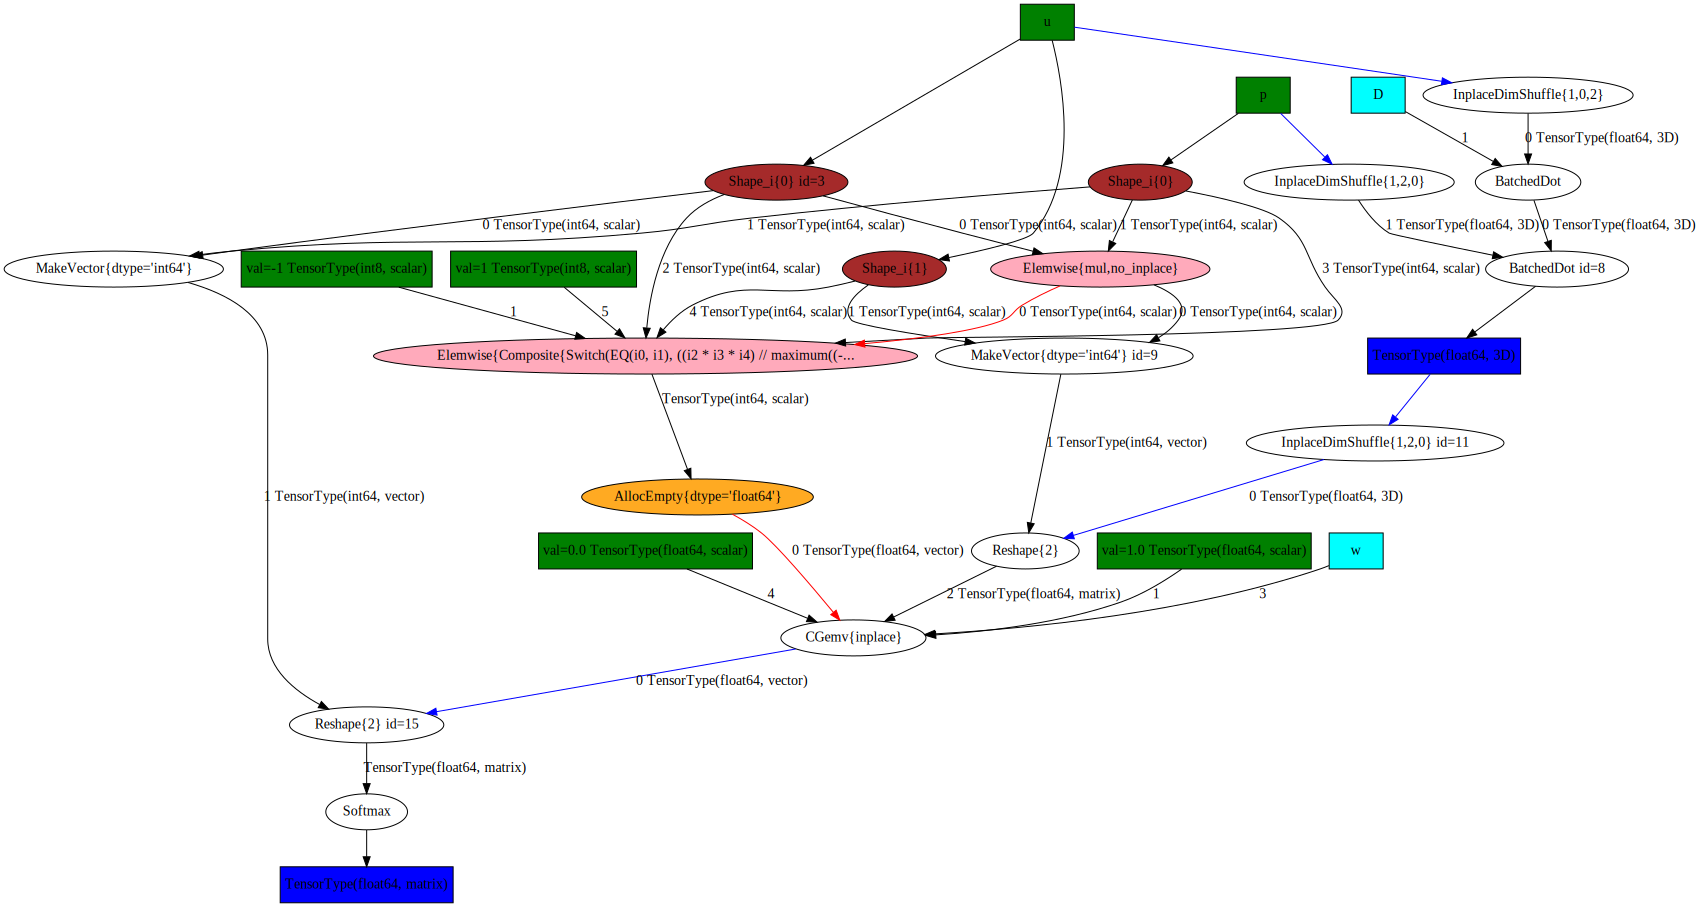

In [110]:
## Only works with a simplified model without Ds
from IPython.display import SVG
SVG(theano.printing.pydotprint(predict, outfile="pics/graph.png", var_with_name_simple=True, return_image=True, format='svg'))

In [122]:
import theano.d3viz as d3v
d3v.d3viz(predict, 'pics/graph.html')